<a href="https://colab.research.google.com/github/yj9889/ESAA2/blob/main/220624HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 필사 - [Baseline]2. 전이학습(transfer learning)을 통한 이미지 분류**
https://dacon.io/competitions/official/235874/codeshare/4584?page=1&dtype=recent

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import random
import numpy as np
from tqdm import tqdm

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from multiprocessing import cpu_count
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn import CrossEntropyLoss
from torchvision.models import efficientnet_b3 as efficientnet
from sklearn.model_selection import train_test_split

## **데이터 load, 전처리**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    transforms.Resize([224,224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

PYTORCH 의 ImageFolder 메소드를 사용하면 folder 의 이름을 자동으로 라벨링이 됩니다.

예를 들어 airplane 이라는 folder 내에 이미지 파일들이 있다면, 이미지 파일들의 라벨을 '0' 으로 라벨링이 됩니다.

`train_data = datasets.ImageFolder(root='./data/train/',transform=transform)`

In [3]:
import torchvision

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


모델 평가를 위해 train 데이터에서 validation 데이터를 나누어줍니다.

In [4]:
train_idx, valid_idx = train_test_split(np.arange(len(train_data)), test_size=0.2, 
                                        random_state=42, shuffle=True, stratify=train_data.targets)

모델에 load 할 batch_size 를 설정해 줍니다.

batch_size: 하드웨어에 한번에 load 할 데이터의 크기

num_workers: 데이터 로드 멀티 프로세싱을 위한 파라미터

In [5]:
batch_size = 32
num_workers = int(cpu_count() / 2)

data loader: 데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체


In [6]:
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(train_idx), num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, 
                          sampler=SubsetRandomSampler(valid_idx), num_workers=num_workers)

데이터의 크기를 확인

In [7]:
train_total = len(train_idx)
valid_total = len(valid_idx)

train_batches = len(train_loader)
valid_batches = len(valid_loader)

In [8]:
print('total train imgs :',train_total,'/ total train batches :', train_batches)
print('total valid imgs :',valid_total, '/ total valid batches :', valid_batches)

total train imgs : 40000 / total train batches : 1250
total valid imgs : 10000 / total valid batches : 313


## **Device 설정**

gpu있다고 가정

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

## **모델 불러오기 / 파라미터 설정**
전이학습을 위한 모델을 load 해줍니다.

PYTORCH 의 models 메소드를 사용하면 손쉽게 외부의 모델을 불러올 수 있습니다.

이번 베이스라인에서는 efficientnet_b3 모델을 사용해 볼 것입니다.

사전 학습 모델을 사용하는 것은 부정행위에 해당하니, pretrained 파라미터를 False 로 설정해야 합니다!

pretrained 파라미터를 True 로 설정한다면, ImageNet 이라는 데이터셋을 대상으로 학습된 모델이 load 됩니다.

반면, pretrained 파라미터를 False 로 설정한다면, 모델의 구조만 load 되고 모델의 가중치 들은 load 되지 않습니다.

In [10]:
net = models.efficientnet_b3(pretrained=False)
net.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

모델에 데이터를 학습하기 위해서는 모델의 마지막 layer 의 output size 와 분류할 라벨의 수를 입력해주어야 합니다.

In [11]:
net.fc = nn.Linear(1000, 10)
net = net.to(device) 

모델의 파라미터들을 설정

In [12]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
epochs = 3

## **학습**
반복문

In [13]:
for epoch in range(epochs):
    net.train()
    
    train_loss = 0 
    train_correct = 0
    tqdm_dataset = tqdm(train_loader)
    for x,y in tqdm_dataset:
        x = x.to(device)
        y = y.to(device)
        outputs = net(x)
        loss = criterion(outputs,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
        })

    train_loss = train_loss / train_batches
    train_acc = train_correct / train_total
    
    net.eval()
    
    valid_loss = 0 
    valid_correct = 0
    tqdm_dataset = tqdm(valid_loader)
    with torch.no_grad():
        for x,y in tqdm_dataset:
            x = x.to(device)
            y = y.to(device)
            
            outputs = net(x)
            loss = criterion(outputs, y)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_correct += predicted.eq(y).sum().item()
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(loss.item()),
            })
            
    valid_loss = valid_loss / valid_batches
    valid_acc = valid_correct / valid_total
        
    print('epochs',epoch+1, 'train loss',train_loss,'train acc', train_acc, 'valid loss',valid_loss, 'valid acc',valid_acc)

100%|██████████| 313/313 [00:28<00:00, 10.82it/s, Epoch=1, Loss=1.344729]


epochs 1 train loss 1.6980040632724762 train acc 0.37785 valid loss 1.2512788823999155 valid acc 0.5456


100%|██████████| 313/313 [00:28<00:00, 10.81it/s, Epoch=2, Loss=1.259221]


epochs 2 train loss 1.084540579676628 train acc 0.617 valid loss 0.8654275254700512 valid acc 0.6949


100%|██████████| 313/313 [00:28<00:00, 10.88it/s, Epoch=3, Loss=0.950757]

epochs 3 train loss 0.8095001702785491 train acc 0.7201 valid loss 0.7375889726149769 valid acc 0.7461


## **모델 저장 / 불러오기**

In [14]:
# 학습된 모델의 가중치를 저장합니다.

path = './model.pth'
torch.save(net.state_dict(),path)

In [15]:
# 저장된 모델을 불러옵니다.

path = './model.pth'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

## **추론**
이제 학습이 완료되었습니다!

그럼 test 데이터를 예측해 보아요.

test 데이터를 불러옵니다.

In [16]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(self.img_list[idx]), self.img_labels[idx]

In [18]:
test_set = CustomDataset(transform)

test_loader = DataLoader(test_set, batch_size = batch_size, num_workers=num_workers)

본격적으로 test 데이터를 예측해보아요!

예측을 할 때는 학습이 진행되지 않도록 net.eval() 코드를 작성해주어야 합니다.

데이터가 backpropagation 되어 가중치가 수정되지 않도록 해주는 코드입니다.

In [20]:
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

net.eval()

batch_index = 0

for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    outputs = net(images)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

FileNotFoundError: ignored

예측된 데이터의 라벨은 숫자로 되어있습니다.

train 데이터를 불러올 때 ImageFolder 메소드를 사용해 데이터를 불러왔기 때문입니다.

제출을 위해 라벨을 다시 복원 시켜 줍니다.

In [21]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

NameError: ignored

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv('submit.csv',index=False)

# **[파이썬 딥러닝 텐서플로 ch4. 4 pg. 182~200]**
# **04. 위성 이미지 분류**
## **4-1. 텐서플로 데이터셋 로드**


## **Import**
인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값이 정리되어 있는 EuroSAT 데이터셋 제공(텐서플로)

EU의 코페르니쿠스 지구 관측 프로그램에 의해 제공되는 공용 데이터셋인 Sentinel-2 위성이 관측한 이미지를 기반으로 만들어졌다.

총 27,000장의 위성 사진과 10개의 토지이용분류 값이 매칭되어 제공된다.

In [22]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

## **Dataset**
EuroSAT 데이터셋을 load함수를 사용하여 불러온다. 

*(훈련 셋, 검증 셋), 메타 정보* 순으로 정리되어 반환

info 변수에 저장되는 메타 정보는 `with_info = True` 옵션일 때만 불러올 수 있다. 즉 이 옵션이 False면 메타정보 없이 (훈련 셋, 검증 셋) 형태의 투플로 반환된다.

URL을 통해 데이터를 다운로드하는데, `data_dir` 옵션에 파일 저장 위치를 지정하면 다운로드한 데이터셋 파일을 해당 위치에 저장한다. 여기서는 'dataset' 폴더에 저장했다. 

train 데이터만 제공하기 때문에 80:20으로 구분해 80%는 train_ds, 20%는 valid_ds로 분할하여 저장한다. 

이미지는 (64,64,3) 형태로 확인된다.


In [23]:
#EuroSAT  위성 사진 데이터셋 로드

DATA_DIR = "/content/drive/MyDrive/data/0625"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


EuroSAT 데이터셋의 2가지 유형 중에서 JPEG 이미지로 인코딩한 RGB 데이터셋을 다운로드한 상태.

In [24]:
# 메타데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력.

`show_examples`

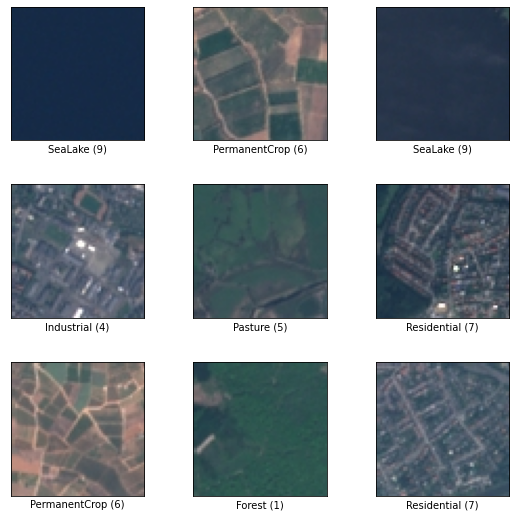

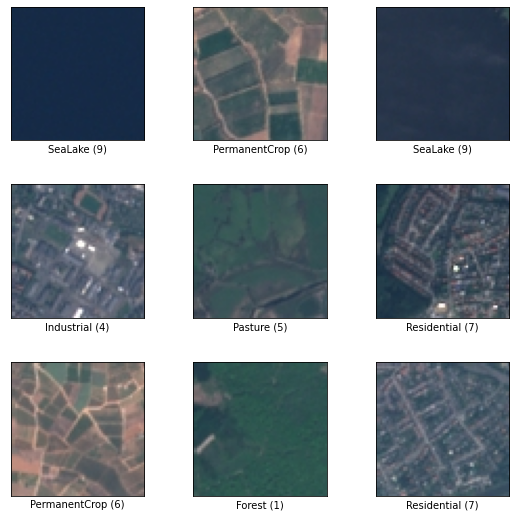

In [25]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,2 (HerbaceousVegetation)
1,,9 (SeaLake)
2,,3 (Highway)
3,,2 (HerbaceousVegetation)
4,,3 (Highway)
5,,0 (AnnualCrop)
6,,1 (Forest)
7,,9 (SeaLake)
8,,8 (River)
9,,0 (AnnualCrop)

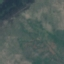
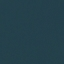
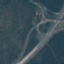
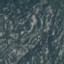
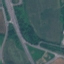
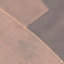
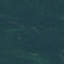
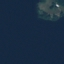
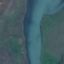
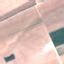

In [26]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

토지 이용 분류에 해당하는 정답 클래스 개수는 10개.

클래스 0: 경작지(AnnualCrop)

클래스 9: 바다/호수(SeaLake)

In [27]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


클래스를 나타내는 숫자 레이블을 메타 데이터의 문자열로 변환.

메타 데이터의 features 값 중에서 label에 해당하는 메타 정보에 `int2str()` 메소드 적용

클래스 6: 영구작물(PermanentCrop)

In [28]:
# 숫자 레이블을 활용하여 문자열 메타데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


## **4-2. 데이터 전처리**
텐서플로의 연산은 float32 숫자 값을 사용하기 때문에, cast 함수를 사용하여 자료형을 float32로 변환.

입력 이미지는 0~255 범위의 픽셀 값을 갖기 때문에, 255로 나눠서 정규화

=> 이 모든 과정을 처리하는 `preprocess_data` 함수 적용


---


map 함수: 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드. 전처리 과정에서 매우 유용.

`num_parallel_calls` 옵션을 `autotune`으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화(하드웨어 리소스를 병렬로 매핑하여 처리)


---

정규화 변환 후 `shuffle()` 메소드 적용하여 순서를 랜덤하게 섞음. 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니 배치를 생성할 때 입력 순서에 무작위성 부여하는 개념.


---


`BUFFER_SIZE=1000, BATCH_SIZE=64`

: 처음 1000개의 데이터를 가져와 섞고 여기서 64개의 데이터를 랜덤하게 선택해서 하나의 배치를 구성.(이때 64개가 추출되어 미니 배치를 구성하고 학습에 사용되면, 다시 64개의 데이터가 버퍼에 추가되어 항상 1000개의 버퍼 구성)


---

`prefetch()`: 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템 조율. 병렬 처리를 통해 모델 훈련 시간 단축



In [29]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

## **4-3. 모델 훈련 및 검증**
배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛을 2개 연결하고, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 Sequential API로 생성.

In [30]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표를 설정하고, 모델을 50 epochs 훈련.

In [31]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)                   

Epoch 1/50
338/338 [==============================] - 21s 25ms/step - loss: 1.6045 - accuracy: 0.4565 - val_loss: 1.5325 - val_accuracy: 0.5374
Epoch 2/50
338/338 [==============================] - 7s 20ms/step - loss: 1.2048 - accuracy: 0.5857 - val_loss: 0.9328 - val_accuracy: 0.6970
Epoch 3/50
338/338 [==============================] - 7s 20ms/step - loss: 1.0424 - accuracy: 0.6386 - val_loss: 0.7286 - val_accuracy: 0.7596
Epoch 4/50
338/338 [==============================] - 7s 21ms/step - loss: 0.9080 - accuracy: 0.6842 - val_loss: 0.7024 - val_accuracy: 0.7644
Epoch 5/50
338/338 [==============================] - 7s 20ms/step - loss: 0.7874 - accuracy: 0.7238 - val_loss: 0.5534 - val_accuracy: 0.8131
Epoch 6/50
338/338 [==============================] - 7s 20ms/step - loss: 0.7202 - accuracy: 0.7449 - val_loss: 0.5175 - val_accuracy: 0.8319
Epoch 7/50
338/338 [==============================] - 7s 20ms/step - loss: 0.6607 - accuracy: 0.7684 - val_loss: 0.5391 - val_accuracy: 0.829

모델은 10 epoch까지는 빠른 속도로 훈련이 진행되면서 손실함수 급격히 감소

하지만 그 이후로는 검증 셋에 대한 손실함수가 더이상 줄어들지 않고 과대적합 경향

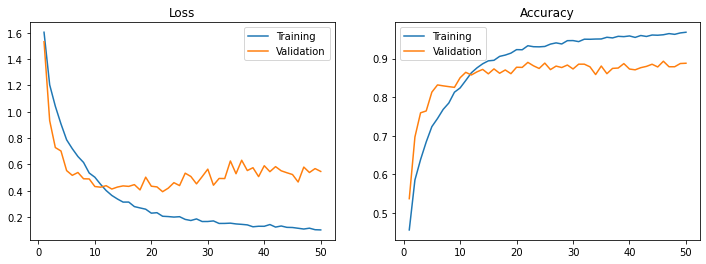

In [32]:
# 손실함수, 정확도 그래프 그리기 

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 50)

## **4-4. 데이터 증강(Data Augmentation)**
배치 정규화, dropout 등을 적용해도 과대적합 발생했음.

이미지 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 robust한 성능을 확보하는 기법

이미지 데이터에 여러 변형을 주어 훈련 데이터의 다양성 확보하는 방식. 모델이 새 데이터에 대한 예측력 강화하는 개념


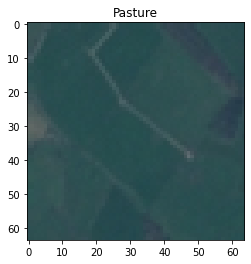

In [37]:
# 샘플 이미지 선정
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [38]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

`tf.image` 모듈의` flip_left_right `함수를 사용해 이미지 좌우 반전

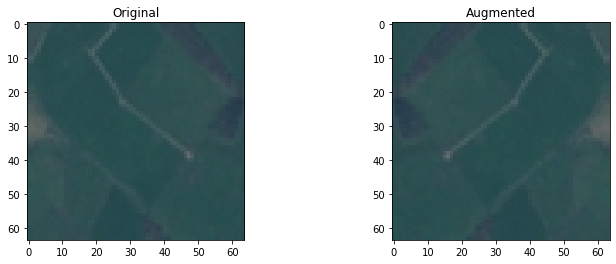

In [39]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

`flip_up_down`

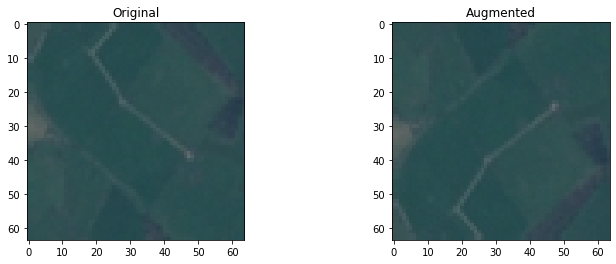

In [40]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

`rot90` 반시계 90도 회전

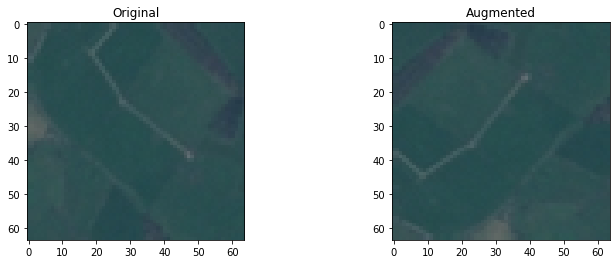

In [41]:
# 회전 
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

`transpose`: 이미지 텐서 행렬의 행과 열 위치 바꿈(행렬의 도치)

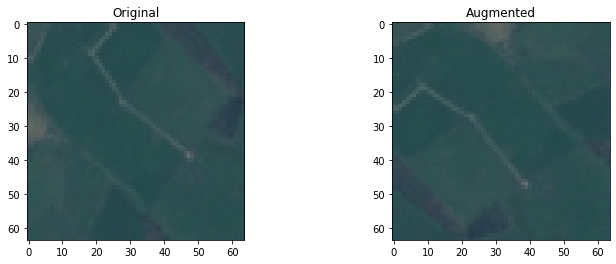

In [42]:
# transpose 
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

`central_crop`: 이미지의 중심에서 일정 부분 잘라냄

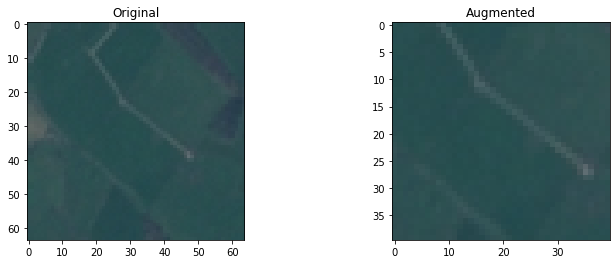

In [43]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

`resize_with_crop_or_pad` 함수: 원본의 이미지 키움

`random_crop` 함수: 원본 크기와 같게 상하좌우 랜덤 방향으로 shift(이동)

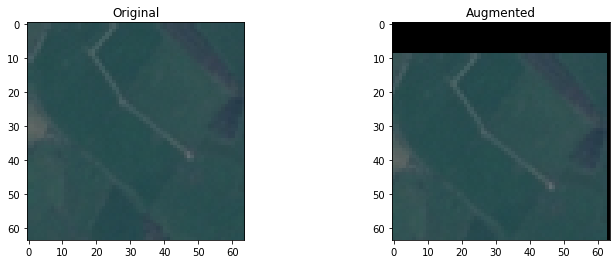

In [44]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

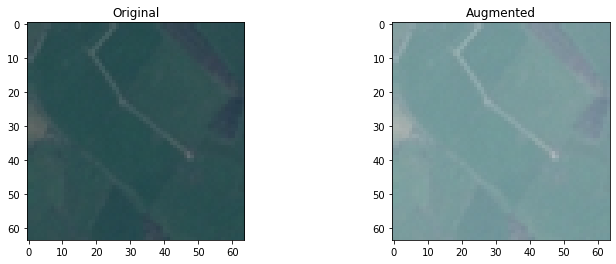

In [45]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

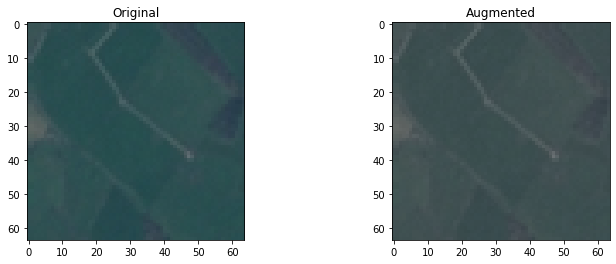

In [46]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

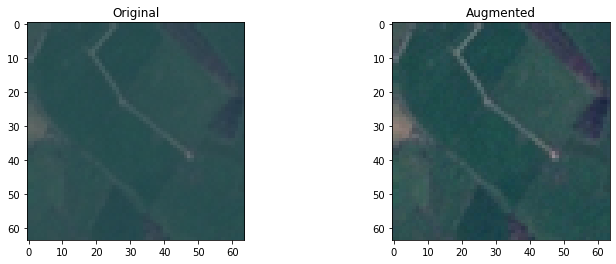

In [47]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

이미지 증강 효과에 랜덤성을 부여하기 위해 tf.image 모듈에서 지원하는 함수 중에서 'random_'으로 시작하는 함수 적용

`map` 함수로 원본 데이터셋에 적용하고, `shuffle`과 `batch` 함수 적용해 미니 배치로 만들어줌.

In [48]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


모델 인스턴스 생성하고, 컴파일을 거쳐 50 epoch 동안 훈련시킴.

데이터 증강 전후 모델의 성능 자체는 큰 차이X

In [49]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)      

Epoch 1/50
338/338 [==============================] - 11s 31ms/step - loss: 2.0338 - accuracy: 0.2751 - val_loss: 1.8759 - val_accuracy: 0.3648
Epoch 2/50
338/338 [==============================] - 9s 26ms/step - loss: 1.7415 - accuracy: 0.3550 - val_loss: 1.5130 - val_accuracy: 0.4615
Epoch 3/50
338/338 [==============================] - 9s 24ms/step - loss: 1.5894 - accuracy: 0.3938 - val_loss: 1.3636 - val_accuracy: 0.4667
Epoch 4/50
338/338 [==============================] - 9s 25ms/step - loss: 1.4767 - accuracy: 0.4258 - val_loss: 1.2946 - val_accuracy: 0.5013
Epoch 5/50
338/338 [==============================] - 9s 26ms/step - loss: 1.3822 - accuracy: 0.4613 - val_loss: 1.1663 - val_accuracy: 0.5641
Epoch 6/50
338/338 [==============================] - 9s 26ms/step - loss: 1.3243 - accuracy: 0.4873 - val_loss: 1.1363 - val_accuracy: 0.5752
Epoch 7/50
338/338 [==============================] - 9s 25ms/step - loss: 1.2946 - accuracy: 0.5034 - val_loss: 1.1283 - val_accuracy: 0.575

훈련 셋과 검증 셋에 대한 손실함수는 50epoch 동안 계속 줄어들고 정확도는 우상향하면서 개선.

즉, 과대적합 문제 상당히 해소

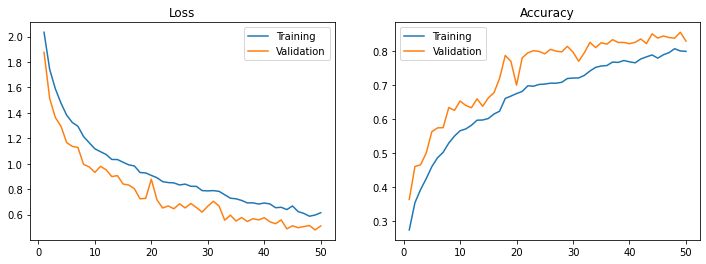

In [50]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

## **4-5. ResNet 사전 학습 모델**
케라스에서 모델 인스턴스 직접 불러옴

예제) ResNet50V2 버전 사용.

`input_shape`에 (64,64,3) 지정

원래 ResNet 모델의 입력 크기는 (224,224,3) 이지만, 케라스에서 이미지 크기를 우리가 지정한 크기로 맞춰서 줄여주고 분류하려는 클래스 레이블의 개수(10)를 `classes` 속성에 지정

`include_top=False`: 기존 ResNet 모델의 top 층은 이미지넷 경진 대회에 맞는 분류기이므로 False로 지정하여 Top층 제거해 줌. 이 제거된 부분에 우리가 해결하려는 문제에 맞는 최종 분류기를 대체해 추가하게 됨

In [53]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, 
                               weights='imagenet',
                               input_shape=[64, 64, 3])
, 
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='/content/drive/MyDrive/data/0625/resnet50.png')

ImportError: ignored

`NUM_CLASSES=10` (위성 이미지의 클래스 레이블 개수)

최종적으로 10개의 클래스에 대한 다중 분류를 할 수 있도록 Dense 레이어의 노드 개수와 softmax 활성화함수 지정

In [54]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [55]:
# 모델 컴파일
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
tc_history = tc_model.fit(train_aug, 
                          validation_data=valid_aug, 
                          epochs=50)      

Epoch 1/50
338/338 [==============================] - 19s 42ms/step - loss: 1.0084 - accuracy: 0.6751 - val_loss: 0.6258 - val_accuracy: 0.7939
Epoch 2/50
338/338 [==============================] - 13s 36ms/step - loss: 0.7191 - accuracy: 0.7692 - val_loss: 0.5594 - val_accuracy: 0.8081
Epoch 3/50
338/338 [==============================] - 13s 36ms/step - loss: 0.6389 - accuracy: 0.7960 - val_loss: 0.5279 - val_accuracy: 0.8269
Epoch 4/50
338/338 [==============================] - 13s 37ms/step - loss: 0.5938 - accuracy: 0.8106 - val_loss: 0.5063 - val_accuracy: 0.8341
Epoch 5/50
338/338 [==============================] - 13s 37ms/step - loss: 0.5551 - accuracy: 0.8214 - val_loss: 0.4875 - val_accuracy: 0.8370
Epoch 6/50
338/338 [==============================] - 13s 37ms/step - loss: 0.5339 - accuracy: 0.8283 - val_loss: 0.4777 - val_accuracy: 0.8387
Epoch 7/50
338/338 [==============================] - 13s 37ms/step - loss: 0.5195 - accuracy: 0.8303 - val_loss: 0.4659 - val_accuracy:

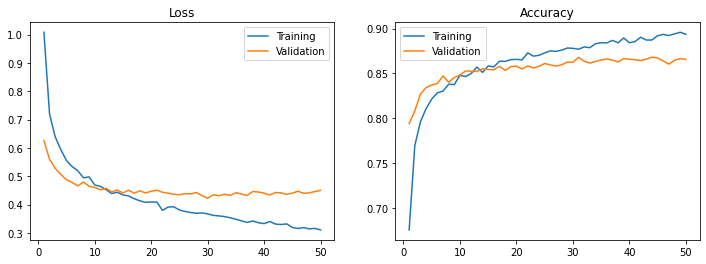

In [56]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(tc_history, 50)